# Models for Multi-Reviewer Labels

In [1]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dense, Activation, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

In [11]:
import os, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import cohen_kappa_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from keras_addon import ImageFrameGenerator, AUCCheckPoint

from DL_utils import plot_roc

In [5]:
path  =  "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/colonoscopy2/"
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)
data_path = path+'subset_adjudication/'

In [6]:
batch_size = 32

## Preparation
Check up the labels and image files. Split into training and validation sets. 

In [18]:
filenames = os.listdir(path+'all_images/')

In [10]:
labels = pd.read_csv(path+'UC_FINAL_Adjudication.csv')

In [11]:
pd.crosstab(labels.Mayo_Rev1_Corrected, labels.Mayo_Rev2_Corrected, margins=True)

Mayo_Rev2_Corrected,0,1,2,3,All
Mayo_Rev1_Corrected,,,,,
0,7058,2049,52,1,9160
1,500,1875,1040,15,3430
2,5,144,1667,589,2405
3,0,1,217,1301,1519
All,7563,4069,2976,1906,16514


In [13]:
pd.crosstab(labels.Mayo_Rev1_Corrected, labels.Mayo_Rev2_Corrected, normalize='index')

Mayo_Rev2_Corrected,0,1,2,3
Mayo_Rev1_Corrected,,,,
0,0.770524,0.223690,0.005677,0.000109
1,0.145773,0.546647,0.303207,0.004373
2,0.002079,0.059875,0.693139,0.244906
3,0.000000,0.000658,0.142857,0.856485


In [14]:
pd.crosstab(labels.adj_score, labels.Mayo_Rev2_Corrected, normalize='index')

Mayo_Rev2_Corrected,0,1,2,3
adj_score,,,,
0,0.819826,0.159745,0.019647,0.000781
1,0.061999,0.755859,0.172056,0.010086
2,0.003228,0.035109,0.843826,0.117837
3,0.001172,0.001757,0.075571,0.921500


Make a subset copy of the images, so the generator can run faster. 

In [15]:
labels.shape

(16514, 7)

In [19]:
labeled = set(labels.basefile)

from shutil import copyfile

for f in filenames:
    if f in labeled:
        copyfile(path+'all_images/'+f, path+'subset_adjudication/'+f)

Create labels for multi-binary classification:

In [11]:
labels['split0_123'] = (labels.adj_score>0).astype(int)
labels['split01_23'] = (labels.adj_score>1).astype(int)
labels['split012_3'] = (labels.adj_score>2).astype(int)

In [23]:
labels.head()

,basefile,pathname,SourceReportName,Mayo_Rev1_Corrected,Mayo_Rev2_Corrected,Corrected_ScoreDiff,adj_score,split0_123,split01_23,split012_3
0,BM_col_1000-2.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,2,3,1,2,1,1,0
1,BM_col_1000-3.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,2,3,1,2,1,1,0
2,BM_col_1000-5.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,0,0,0,0,0,0,0
3,BM_col_1000-6.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,0,1,1,0,0,0,0
4,BM_col_1000-7.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,0,0,0,0,0,0,0


In [26]:
labels.adj_score.value_counts()

0    8958
1    3371
2    2478
3    1707
Name: adj_score, dtype: int64

In [27]:
len(labels), len(labels.SourceReportName.value_counts())

(16514, 3082)

Splitting of training/validation and testing (I use "train" to denote training and validation data, and "tst" to denote testing data; use "trn" and "val" for the training/validation splitting):

In [12]:
labels = labels.reset_index(drop=True)
split = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=24)
ind = split.split(labels, groups=labels['SourceReportName'])
train_ind, tst_ind = next(ind)
train_patients = set(labels.loc[train_ind, 'SourceReportName'])
tst_patients = set(labels.loc[tst_ind, 'SourceReportName'])
train_df = labels.loc[train_ind]
tst_df = labels.loc[tst_ind]

In [13]:
train_ind.shape, tst_ind.shape, len(train_patients), len(tst_patients)

((14847,), (1667,), 2773, 309)

In [30]:
train_df.to_csv(path+'train_labels.csv', index=False)
tst_df.to_csv(path+'tst_labels.csv', index=False)

Splitting of training and validation sets:

In [7]:
labels = pd.read_csv(path+'train_labels.csv')

In [8]:
labels = labels.reset_index(drop=True)
split = GroupShuffleSplit(n_splits=1, test_size=0.11, random_state=24)
ind = split.split(labels, groups=labels['SourceReportName'])
trn_ind, val_ind = next(ind)

trn_patients = set(labels.loc[trn_ind, 'SourceReportName'])
val_patients = set(labels.loc[val_ind, 'SourceReportName'])

trn_df = labels.loc[trn_ind]
val_df = labels.loc[val_ind]

In [9]:
trn_ind.shape, val_ind.shape, len(trn_patients), len(val_patients)

((13165,), (1682,), 2467, 306)

In [34]:
val_df.split012_3.value_counts()

0    1493
1     189
Name: split012_3, dtype: int64

In [35]:
val_df.adj_score.value_counts()

0    863
1    330
2    300
3    189
Name: adj_score, dtype: int64

## Data Generator

In [7]:
from keras_addon import ImageFrameGenerator, AUCCheckPoint

In [91]:
import keras_addon
from importlib import reload
reload(keras_addon)

<module 'keras_addon' from '/home/wsliu/Codes/DLproj/keras_addon.py'>

In [8]:
train_gen = ImageFrameGenerator( 
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

In [9]:
validation_gen = ImageFrameGenerator()

In [13]:
trn_itr = train_gen.flow_from_frame(data_path, trn_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 13165 images to generate mini-batches.


In [14]:
val_itr = validation_gen.flow_from_frame(data_path, val_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1682 images to generate mini-batches.


In [14]:
train_itr = train_gen.flow_from_frame(data_path, train_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 14847 images to generate mini-batches.


## Model with 3 binary output

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(2, activation='softmax', name='split0_123')(x)
output2 = Dense(2, activation='softmax', name='split01_23')(x)
output3 = Dense(2, activation='softmax', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [18]:
checkpointer = ModelCheckpoint(filepath=model_path+'binary3_valloss_1111.h5', verbose=0, save_best_only=True, 
                               save_weights_only=True)
auccheckpt = AUCCheckPoint(filepath=model_path+'binary3_auc_1111.h5', validation_itr=val_itr)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=40)

In [18]:
class_weight = {'split0_123':{0:len(trn_df)/sum(trn_df.split0_123==0), 1:len(trn_df)/sum(trn_df.split0_123==1)}, 
               'split01_23':{0:len(trn_df)/sum(trn_df.split01_23==0), 1:len(trn_df)/sum(trn_df.split01_23==1)}, 
               'split012_3':{0:len(trn_df)/sum(trn_df.split012_3==0), 1:len(trn_df)/sum(trn_df.split012_3==1)}}

In [23]:
class_weight

{'split012_3': {0: 0.10292442081276111, 1: 0.8970755791872389},
 'split01_23': {0: 0.5025446259020129, 1: 1.497455374097987},
 'split0_123': {0: 0.45507026205848844, 1: 0.5449297379415116}}

In [27]:
history = model.fit_generator(trn_itr, steps_per_epoch=trn_itr.n // batch_size, epochs=2, 
                              validation_data=val_itr, validation_steps=val_itr.n // batch_size, 
                              callbacks=[checkpointer, auccheckpt, reduce_lr, earlystop], class_weight = class_weight, 
                                verbose=1)

Epoch 1/2
411/411 [==============================] - 607s 1s/step - loss: 0.4941 - split0_123_loss: 0.2587 - split01_23_loss: 0.1659 - split012_3_loss: 0.0696 - val_loss: 1.6972 - val_split0_123_loss: 0.7067 - val_split01_23_loss: 0.6195 - val_split012_3_loss: 0.3710
AUC_split0_123: 0.8108
AUC_split01_23: 0.8271
AUC_split012_3: 0.7556
Mean AUC: 0.7978

Epoch 2/2
411/411 [==============================] - 589s 1s/step - loss: 0.4260 - split0_123_loss: 0.2247 - split01_23_loss: 0.1417 - split012_3_loss: 0.0596 - val_loss: 1.6510 - val_split0_123_loss: 0.8736 - val_split01_23_loss: 0.5240 - val_split012_3_loss: 0.2534
AUC_split0_123: 0.8585
AUC_split01_23: 0.9169
AUC_split012_3: 0.9226
Mean AUC: 0.8993



### Result Evaluation

In [65]:
with open('output/binary3_auc_0528.pkl', 'rb') as f:
    auc_history = pickle.load(f)

Text(0,0.5,'AUCs')

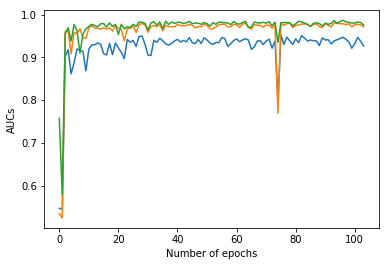

In [66]:
plt.plot(auc_history['split0_123'])
plt.plot(auc_history['split01_23'])
plt.plot(auc_history['split012_3'])
plt.xlabel('Number of epochs')
plt.ylabel('AUCs')

In [88]:
tst_df = pd.read_csv(path+'tst_labels.csv')
tst_df = tst_df.reset_index(drop=True)

In [50]:
validation_gen = ImageFrameGenerator()

In [98]:
tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1667 images to generate mini-batches.


In [52]:
model.load_weights(model_path+'binary3_auc_1111.h5')

In [53]:
y = model.predict_generator(tst_itr, verbose=1)

53/53 [==============================] - 24s 458ms/step


In [54]:
y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)

In [55]:
y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values

In [56]:
y_pred.shape, y_true.shape

((1667, 3), (1667, 3))

{0: 0.8703516110533775, 1: 0.9198552348403632, 2: 0.9231211656441717}

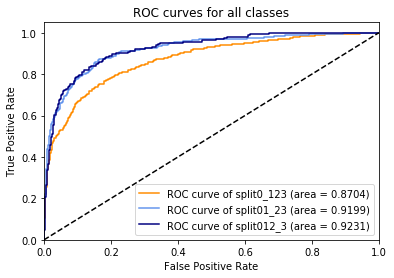

In [57]:
plot_roc(y_pred, y_true, classes=['split0_123', 'split01_23', 'split012_3'])

In [103]:
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)

In [104]:
score4[:, 0] = 1 - y_pred[:, 0]
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

In [105]:
mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [106]:
mayo_true = tst_df.Mayo_score
mayo_true.name = 'Mayo_true'

## Test on Video data

Copy all video images to the same folder, and rename them as "subject id"+"frame". 

In [7]:
from shutil import copyfile

In [28]:
phase1_path = path+'../UC_colonoscopy/UC_Images_Labels/'

In [37]:
phase1_folders = [o for o in os.listdir(phase1_path) if os.path.isdir(os.path.join(phase1_path,o))]

In [39]:
for folder in phase1_folders:
    for file in os.listdir(phase1_path+folder):
        copyfile(phase1_path+folder+'/'+file, path+'all_video_images/'+folder+file)

In [40]:
phase2_path = path+'Ryan_qc_0525/video_data/'

In [41]:
phase2_folders = [o for o in os.listdir(phase2_path) if os.path.isdir(os.path.join(phase2_path,o))]

In [43]:
for folder in phase2_folders:
    for file in os.listdir(phase2_path+folder):
        copyfile(phase2_path+folder+'/'+file, path+'all_video_images/'+folder+file)

In [8]:
phase3_path = path+'additional_video_data1128/'

In [9]:
phase3_folders = [o for o in os.listdir(phase3_path) if os.path.isdir(os.path.join(phase3_path,o))]

In [11]:
phase3_folders = ['058', '113']

In [12]:
for folder in phase3_folders:
    for file in os.listdir(phase3_path+folder):
        copyfile(phase3_path+folder+'/'+file, path+'all_video_images/'+folder+file)

In [10]:
vfilenames = os.listdir(path+'all_video_images/')

In [11]:
vfilenames = set(vfilenames)

In [17]:
len(vfilenames)

39890

In [8]:
video_labels = pd.read_excel(path+'VideoTestSet_labels_29NOV2018.xlsx')

In [13]:
video_labels.shape

(11549, 13)

In [38]:
video_labels.head()

,ID,basefile,pathname,file_seq,SubjectID,Time_sec,Video_time,Mayo_0,Mayo_1,Mayo_2,Mayo_3
0,120088,frame-000243.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,244.0,001,244.0,00:04:04,False,True,False,False
1,120089,frame-000244.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,245.0,001,245.0,00:04:05,False,True,False,False
2,120090,frame-000245.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,246.0,001,246.0,00:04:06,False,True,False,False
3,120091,frame-000246.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,247.0,001,247.0,00:04:07,False,True,False,False
4,120092,frame-000247.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,248.0,001,248.0,00:04:08,False,True,False,False


In [9]:
video_labels['filename'] = [s+b for s, b in zip(video_labels.SubjectID, video_labels.basefile)]

In [12]:
video_labels = video_labels.loc[video_labels.filename.isin(vfilenames)]

In [48]:
video_labels.loc[video_labels[['Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3']].apply(sum, axis=1)!=1]

,ID,basefile,pathname,file_seq,SubjectID,Time_sec,Video_time,Mayo_0,Mayo_1,Mayo_2,Mayo_3,filename
85,120177,frame-000332.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,333.0,001,333.0,00:05:33,False,False,False,False,001frame-000332.jpg
91,120184,frame-000339.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,340.0,001,340.0,00:05:40,False,False,False,False,001frame-000339.jpg
94,120187,frame-000342.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,343.0,001,343.0,00:05:43,False,False,False,False,001frame-000342.jpg
97,120190,frame-000345.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,346.0,001,346.0,00:05:46,False,False,False,False,001frame-000345.jpg
98,120192,frame-000347.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,348.0,001,348.0,00:05:48,False,False,False,False,001frame-000347.jpg
131,120301,frame-000456.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,457.0,001,457.0,00:07:37,False,False,False,False,001frame-000456.jpg
132,120305,frame-000460.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,461.0,001,461.0,00:07:41,False,False,False,False,001frame-000460.jpg
133,120507,frame-000662.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,663.0,001,663.0,00:11:03,False,False,False,False,001frame-000662.jpg
134,120509,frame-000664.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,665.0,001,665.0,00:11:05,False,False,False,False,001frame-000664.jpg
135,120511,frame-000666.jpg,\\maize.umhsnas.med.umich.edu\IntMedGI-Stidham...,667.0,001,667.0,00:11:07,False,False,False,False,001frame-000666.jpg


In [13]:
video_labels = video_labels.loc[video_labels[['Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3']].apply(sum, axis=1)==1]

In [14]:
video_labels = video_labels.dropna(subset=['filename', 'Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3'])

In [50]:
video_labels.shape, len(video_labels.SubjectID.value_counts())

((11492, 12), 30)

In [16]:
video_labels['split0_123'] = (~video_labels.Mayo_0).astype(int)
video_labels['split01_23'] = (video_labels.Mayo_2 | video_labels.Mayo_3).astype(int)
video_labels['split012_3'] = video_labels.Mayo_3.astype(int)

In [17]:
video_labels['Mayo_score'] = 0
video_labels.loc[video_labels.Mayo_1, 'Mayo_score'] = 1
video_labels.loc[video_labels.Mayo_2, 'Mayo_score'] = 2
video_labels.loc[video_labels.Mayo_3, 'Mayo_score'] = 3

In [53]:
video_labels.Mayo_score.value_counts()

0    8143
1    1578
2    1123
3     648
Name: Mayo_score, dtype: int64

In [54]:
video_labels.shape

(11492, 16)

In [55]:
video_labels.to_csv(path+'video_labels.csv', index=False)

In [7]:
video_labels = pd.read_csv(path+'video_labels.csv')

In [56]:
from shutil import copyfile

In [57]:
labeled = set(video_labels.filename)

for f in vfilenames:
    if f in labeled:
        copyfile(path+'all_video_images/'+f, path+'video_subset/'+f)

### Prediction by 3 binary model

In [8]:
tst_gen = ImageFrameGenerator()
tst_itr = tst_gen.flow_from_frame(path+'video_subset/', video_labels, 'filename', 
                                   ['Mayo_score'], label_types=['categorical'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 11518 images in the directory.
Using Mayo_score as categorical label, with levels: {0: 0, 1: 1, 2: 2, 3: 3}
Using 11492 images to generate mini-batches.


In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(2, activation='softmax', name='split0_123')(x)
output2 = Dense(2, activation='softmax', name='split01_23')(x)
output3 = Dense(2, activation='softmax', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [20]:
model.load_weights(model_path+'binary3_auc_all.h5')

In [21]:
y = model.predict_generator(tst_itr, verbose=1)

360/360 [==============================] - 978s 3s/step


In [22]:
y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)

In [39]:
y_true = video_labels[['split0_123', 'split01_23', 'split012_3']].values

In [24]:
y_pred.shape, y_true.shape

((11492, 3), (11492, 3))

{0: 0.9499291864403336, 1: 0.9616355319628823, 2: 0.9690050195590895}

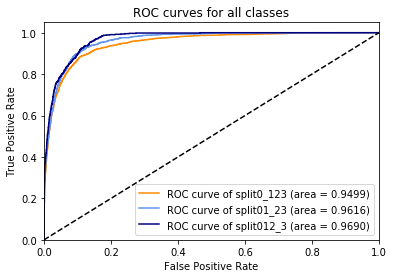

In [25]:
plot_roc(y_pred, y_true, classes=['split0_123', 'split01_23', 'split012_3'])

In [41]:
fpr, tpr, thresh = roc_curve(y_true[:, 1], y_pred[:, 1])

In [42]:
optiaml_index = np.argmin((1-tpr)**2+fpr**2)

In [22]:
import DL_utils
reload(DL_utils)

<module 'DL_utils' from '/home/wsliu/Codes/DLproj/DL_utils.py'>

In [23]:
from DL_utils import plot_roc

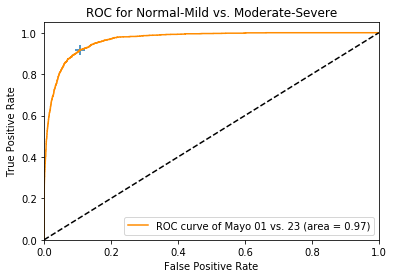

In [43]:
plot_roc(y_pred[:, 1], y_true[:, 1], classes=['Mayo 01 vs. 23'], title='ROC for Normal-Mild vs. Moderate-Severe', n_digits=2)
plt.scatter(fpr[optiaml_index], tpr[optiaml_index], marker='+', s=100)
plt.savefig('plots/roc01_23_video_Mar22.eps', dpi=3000)

In [26]:
np.save('output/y_pred_video_all_auc.npy', y_pred)

In [40]:
y_pred = np.load('output/y_pred_video_all_valloss.npy')

In [16]:
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)

score4[:, 0] = 1 - y_pred[:, 0]
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [17]:
mayo_true = video_labels.Mayo_score.reset_index(drop=True)
mayo_true.name = 'Mayo_true'

In [71]:
cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='linear')

0.7274866302283287

In [39]:
cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='quadratic')

0.7490517161515529

In [18]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.753039,0.205821,0.030947,0.010193
1,0.127376,0.676172,0.188847,0.007605
2,0.018700,0.158504,0.642921,0.179875
3,0.024691,0.020062,0.276235,0.679012


In [19]:
pd.crosstab(index=mayo_true, columns=mayo_pred, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,6132,1676,252,83,8143
1,201,1067,298,12,1578
2,21,178,722,202,1123
3,16,13,179,440,648
All,6370,2934,1451,737,11492


In [41]:
thresh = 0.5
print('Threshold:', thresh)
print('Sensitivity', sum((y_pred[:, 1]>thresh) & (y_true[:, 1]==1))/sum(y_true[:, 1]==1))
print('Specificity', sum((y_pred[:, 1]<thresh) & (y_true[:, 1]==0))/sum(y_true[:, 1]==0))
print('PPV', sum((y_pred[:, 1]>thresh) & (y_true[:, 1]==1))/sum(y_pred[:, 1]>thresh))
print('NPV', sum((y_pred[:, 1]<thresh) & (y_true[:, 1]==0))/sum(y_pred[:, 1]<thresh))

Threshold: 0.5
Sensitivity 0.8740824392998306
Specificity 0.9261392860816788
PPV 0.6831421006178288
NPV 0.9758291784088445


In [42]:
sum(y_true[:, 1]==0), sum(y_true[:, 1]==1)

(9721, 1771)

In [7]:
N1 = 9721
N2 = 1771
auc = 0.9664

In [8]:
Q1 = auc/(2-auc)
Q2 = 2*auc**2/(1+auc)

In [10]:
SE = np.sqrt((auc*(1-auc)+(N1-1)*(Q1-auc**2)+(N2-1)*(Q2-auc**2))/N1/N2)

In [20]:
auc-1.96*SE, auc+1.96*SE, SE

(0.963467500695883, 0.969332499304117, 0.0014961731143453964)

In [35]:
var = 0.7491

SE=np.sqrt(var*(1-var)/(N1+N2))

In [36]:
SE, var-1.96*SE - 1/2/(N1+N2), var+1.96*SE +1/2/(N1+N2)

(0.0040441049773557195, 0.7411300457167114, 0.7570699542832886)

In [30]:
n=N1+N2
z = 1.96

In [32]:
(2*n*var+z**2-z*np.sqrt(z**2+4*n*var*(1-var)))/2/(n+z**2), (2*n*var+z**2+z*np.sqrt(z**2+4*n*var*(1-var)))/2/(n+z**2)

(0.9728273618002939, 0.9784546391625585)

## Cross Validation

### Splitting for 10-fold cross validation

In [64]:
from sklearn.model_selection import GroupKFold

In [58]:
train_df = pd.read_csv(path+'train_labels.csv')
tst_df = pd.read_csv(path+'tst_labels.csv')

In [59]:
all_df = pd.concat([train_df, tst_df])

In [60]:
all_df = all_df.reset_index(drop=True)

In [63]:
all_df.shape, len(all_df.SourceReportName.value_counts())

((16514, 10), 3082)

In [67]:
split = GroupKFold(n_splits=10)

In [68]:
fold = 0
for train_ind, tst_ind in split.split(all_df, groups=all_df.SourceReportName):
    train_df = all_df.loc[train_ind]
    tst_df = all_df.loc[tst_ind]
    train_df.to_csv(path+'CV_adjudication/train_labels'+str(fold)+'.csv', index=False)
    tst_df.to_csv(path+'CV_adjudication/tst_labels'+str(fold)+'.csv', index=False)
    fold += 1

In [69]:
patient_sets = []
for j in range(10):
    df = pd.read_csv(path+'CV_adjudication/tst_labels'+str(j)+'.csv')
    patient_sets.append(set(df.SourceReportName))

In [70]:
[len(s) for s in patient_sets]

[308, 308, 309, 309, 308, 308, 308, 308, 308, 308]

In [75]:
for ps in patient_sets:
    print(len(patient_sets[7].intersection(ps)))

0
0
0
0
0
0
0
308
0
0


### Summary of Results

In [105]:
from sklearn.metrics import roc_curve, auc

In [106]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(2, activation='softmax', name='split0_123')(x)
output2 = Dense(2, activation='softmax', name='split01_23')(x)
output3 = Dense(2, activation='softmax', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [11]:
validation_gen = ImageFrameGenerator()

In [27]:
thresh = 0.5
auc01_23 = []
sensi01_23 = []
speci01_23 = []
ppv01_23 = []
npv01_23 = []
acc0 = []
acc1 = []
acc2 = []
acc3 = []
kappa_linear = []
kappa_quad = []

In [28]:
for cv in range(10):
    tst_df = pd.read_csv(path+'CV_adjudication/tst_labels'+str(cv)+'.csv')
    tst_df = tst_df.reset_index(drop=True)
    tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)
    model.load_weights(model_path+'CV_adjudication/binary3_auc'+str(cv)+'1.h5')
    y = model.predict_generator(tst_itr, verbose=1)

    y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)
    y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values

    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    auc01_23.append(auc(fpr, tpr))
    
    sensi01_23.append(sum((y_pred[:, 1]>thresh) & (y_true[:, 1]==1))/sum(y_true[:, 1]==1))
    speci01_23.append(sum((y_pred[:, 1]<thresh) & (y_true[:, 1]==0))/sum(y_true[:, 1]==0))
    ppv01_23.append(sum((y_pred[:, 1]>thresh) & (y_true[:, 1]==1))/sum(y_pred[:, 1]>thresh))
    npv01_23.append(sum((y_pred[:, 1]<thresh) & (y_true[:, 1]==0))/sum(y_pred[:, 1]<thresh))
    
    score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)
    score4[:, 0] = 1 - y_pred[:, 0]
    score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
    score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
    score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

    mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')
    mayo_true = tst_df.adj_score
    mayo_true.name = 'Mayo_true'
    
    acc0.append(sum((mayo_pred==0) & (mayo_true==0))/sum(mayo_true==0))
    acc1.append(sum((mayo_pred==1) & (mayo_true==1))/sum(mayo_true==1))
    acc2.append(sum((mayo_pred==2) & (mayo_true==2))/sum(mayo_true==2))
    acc3.append(sum((mayo_pred==3) & (mayo_true==3))/sum(mayo_true==3))

    kappa_linear.append(cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='linear'))
    kappa_quad.append(cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='quadratic'))

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1652 images to generate mini-batches.
52/52 [==============================] - 24s 459ms/step
Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1652 images to generate mini-batches.
52/52 [==============================] - 24s 456ms/step
Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1652 images to generate mini-batches.
52/52 [==============================] - 24s 457ms/step
Foun

New way of calculating 4 scores:

In [7]:
acc0 = []
acc1 = []
acc2 = []
acc3 = []
kappa_linear = []
kappa_quad = []
for tst_seed in range(10):
    tst_df = pd.read_csv(path+'CV_adjudication/tst_labels{}.csv'.format(tst_seed))
    tst_df = tst_df.reset_index(drop=True)
    y_pred_avg = np.load('output/y_pred_avg_auc{}.npy'.format(tst_seed))
    score4 = np.zeros((y_pred_avg.shape[0], y_pred_avg.shape[1]+1), dtype=float)
    score4[:, 3] = y_pred_avg[:, 2]
    score4[:, 2] = y_pred_avg[:, 1]*(1-y_pred_avg[:,2])
    score4[:, 1] = y_pred_avg[:, 0]*(1-y_pred_avg[:,1])*(1-y_pred_avg[:,2])
    score4[:, 0] = (1-y_pred_avg[:, 0])*(1-y_pred_avg[:,1])*(1-y_pred_avg[:,2])
    mayo_pred_avg = pd.Series(score4.argmax(axis=1), name='Mayo_pred')  
    
    mayo_true = tst_df.adj_score
    mayo_true.name = 'Mayo_true'
    
    acc0.append(sum((mayo_pred_avg==0) & (mayo_true==0))/sum(mayo_true==0))
    acc1.append(sum((mayo_pred_avg==1) & (mayo_true==1))/sum(mayo_true==1))
    acc2.append(sum((mayo_pred_avg==2) & (mayo_true==2))/sum(mayo_true==2))
    acc3.append(sum((mayo_pred_avg==3) & (mayo_true==3))/sum(mayo_true==3))

    kappa_linear.append(cohen_kappa_score(mayo_pred_avg.values, mayo_true.values, weights='linear'))
    kappa_quad.append(cohen_kappa_score(mayo_pred_avg.values, mayo_true.values, weights='quadratic'))

In [9]:
np.savez('output/CV_adjudication_avg3_new.npz', acc0=acc0, acc1=acc1, acc2=acc2, acc3=acc3, kappa_l=kappa_linear, 
         kappa_q=kappa_quad)

In [12]:
import statsmodels.stats.api as sms

In [29]:
np.savez('output/CV_adjudication_avg3.npz', auc01_23=auc01_23, sensi01_23=sensi01_23, speci01_23=speci01_23, ppv01_23=ppv01_23, 
         npv01_23=npv01_23, acc0=acc0, acc1=acc1, acc2=acc2, acc3=acc3, kappa_l=kappa_linear, kappa_q=kappa_quad)

In [10]:
load = np.load('output/CV_adjudication_avg3_new.npz')

In [59]:
load = np.load('output/CV_adjudication_avg5_valloss.npz')

In [16]:
x = 'acc3'
print('{0:.4f}'.format(np.mean(load[x])))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(load[x]).tconfint_mean()))

0.6983
(0.6695, 0.7272)


In [19]:
x = 'kappa_q'
print('{0:.4f}'.format(np.mean(load[x])))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(load[x]).tconfint_mean()))

0.8473
(0.8384, 0.8561)


### Single result

In [26]:
tst_seed = 0

In [9]:
train_df = pd.read_csv(path+'CV_adjudication/train_labels{}.csv'.format(tst_seed))

In [27]:
tst_df = pd.read_csv(path+'CV_adjudication/tst_labels{}.csv'.format(tst_seed))
tst_df = tst_df.reset_index(drop=True)

In [12]:
tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1652 images to generate mini-batches.


In [107]:
ys = []
for val_seed in range(1, 4):
    model.load_weights(model_path+'CV_adjudication/binary3_auc{}{}.h5'.format(tst_seed, val_seed))
    ys.append(model.predict_generator(tst_itr, verbose=1))

52/52 [==============================] - 24s 458ms/step


In [108]:
y_preds = []
for y in ys:
    y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)
    y_preds.append(y_pred)

In [109]:
y_pred_avg = np.mean(np.stack(y_preds, axis=0), axis=0)

In [110]:
y_pred_avg.mean(axis=0)

array([0.45695728, 0.27309194, 0.10841713], dtype=float32)

In [28]:
y_pred_avg = np.load('output/y_pred_avg_auc{}.npy'.format(tst_seed))

In [14]:
score4 = np.zeros((y_pred_avg.shape[0], y_pred_avg.shape[1]+1), dtype=float)
score4[:, 0] = 1 - y_pred_avg[:, 0]
score4[:, 1] = y_pred_avg[:, 0]*(1-y_pred_avg[:,1])
score4[:, 2] = y_pred_avg[:, 0]*y_pred_avg[:,1]*(1-y_pred_avg[:,2])
score4[:, 3] = y_pred_avg[:, 0]*y_pred_avg[:,1]*y_pred_avg[:,2]
mayo_pred_avg = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [117]:
score4 = np.zeros((y_pred_avg.shape[0], y_pred_avg.shape[1]+1), dtype=float)
score4[:, 3] = y_pred_avg[:, 2]
score4[:, 2] = y_pred_avg[:, 1]*(1-y_pred_avg[:,2])
score4[:, 1] = y_pred_avg[:, 0]*(1-y_pred_avg[:,1])*(1-y_pred_avg[:,2])
score4[:, 0] = (1-y_pred_avg[:, 0])*(1-y_pred_avg[:,1])*(1-y_pred_avg[:,2])
mayo_pred_avg = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [29]:
mayo_true = tst_df.adj_score
mayo_true.name = 'Mayo_true'
y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values
rev1 = [1-sum((tst_df.Mayo_Rev1_Corrected<=1) & (tst_df.adj_score<=1))/sum(tst_df.adj_score<=1), 
        sum((tst_df.Mayo_Rev1_Corrected>=2) & (tst_df.adj_score>=2))/sum(tst_df.adj_score>=2)]
rev2 = [1-sum((tst_df.Mayo_Rev2_Corrected<=1) & (tst_df.adj_score<=1))/sum(tst_df.adj_score<=1), 
        sum((tst_df.Mayo_Rev2_Corrected>=2) & (tst_df.adj_score>=2))/sum(tst_df.adj_score>=2)]

In [16]:
(cohen_kappa_score(mayo_pred_avg.values, mayo_true.values, weights='linear'), 
 cohen_kappa_score(mayo_pred_avg.values, mayo_true.values, weights='quadratic'))

(0.7725574836525866, 0.8686512280548495)

In [17]:
(cohen_kappa_score(tst_df.Mayo_Rev1_Corrected.values, mayo_true.values, weights='linear'), 
 cohen_kappa_score(tst_df.Mayo_Rev1_Corrected.values, mayo_true.values, weights='quadratic'))

(0.8899027893117093, 0.9411746896552199)

In [18]:
(cohen_kappa_score(tst_df.Mayo_Rev2_Corrected.values, mayo_true.values, weights='linear'), 
 cohen_kappa_score(tst_df.Mayo_Rev2_Corrected.values, mayo_true.values, weights='quadratic'))

(0.8038311539193794, 0.8861769149891277)

In [19]:
(cohen_kappa_score(tst_df.Mayo_Rev1_Corrected.values, tst_df.Mayo_Rev2_Corrected.values, weights='linear'), 
 cohen_kappa_score(tst_df.Mayo_Rev1_Corrected.values, tst_df.Mayo_Rev2_Corrected.values, weights='quadratic'))

(0.723538697237605, 0.8548372282259987)

In [16]:
from sklearn.metrics import roc_curve

In [30]:
fpr, tpr, thresh = roc_curve(y_true[:, 1], y_pred_avg[:, 1])

In [31]:
optiaml_index = np.argmin((1-tpr)**2+fpr**2)

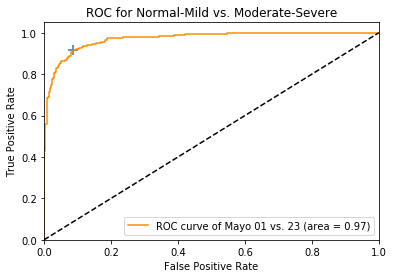

In [38]:
plot_roc(y_pred_avg[:, 1], y_true[:, 1], classes=['Mayo 01 vs. 23'], title='ROC for Normal-Mild vs. Moderate-Severe', n_digits=2)
plt.scatter(fpr[optiaml_index], tpr[optiaml_index], marker='+', s=100)
#plt.scatter(*rev2, marker='+', s=50)
plt.savefig('plots/roc01_23_test_Mar22.eps', dpi=3000, format='eps', quality=95)

In [39]:
rev1, rev2

([0.01146601146601145, 0.9118329466357309],
 [0.07371007371007376, 0.9721577726218097])

In [32]:
pd.crosstab(tst_df.Mayo_Rev1_Corrected, tst_df.adj_score, normalize='index')

Mayo_true,0,1,2,3
Mayo_Rev1_Corrected,,,,
0,0.946681,0.051143,0.002176,0.000000
1,0.150307,0.739264,0.110429,0.000000
2,0.007812,0.039062,0.832031,0.121094
3,0.006623,0.006623,0.033113,0.953642


In [35]:
thresh = 0.5
print('Threshold:', thresh)
print('Sensitivity', sum((y_pred_avg[:, 1]>thresh) & (y_true[:, 1]==1))/sum(y_true[:, 1]==1))
print('Specificity', sum((y_pred_avg[:, 1]<thresh) & (y_true[:, 1]==0))/sum(y_true[:, 1]==0))
print('PPV', sum((y_pred_avg[:, 1]>thresh) & (y_true[:, 1]==1))/sum(y_pred_avg[:, 1]>thresh))
print('NPV', sum((y_pred_avg[:, 1]<thresh) & (y_true[:, 1]==0))/sum(y_pred_avg[:, 1]<thresh))

Threshold: 0.5
Sensitivity 0.8491879350348028
Specificity 0.9541359541359541
PPV 0.8672985781990521
NPV 0.9471544715447154


In [121]:
pd.crosstab(index=mayo_true, columns=mayo_pred_avg, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,815,82,22,3,922
1,87,159,47,6,299
2,11,40,183,22,256
3,0,1,43,131,175
All,913,282,295,162,1652


In [66]:
pd.crosstab(index=mayo_true, columns=mayo_pred_avg, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.901302,0.081345,0.017354,0.000000
1,0.317726,0.548495,0.113712,0.020067
2,0.046875,0.214844,0.644531,0.093750
3,0.005714,0.011429,0.245714,0.737143


### Confidence Measure

In [37]:
confidence_df = pd.DataFrame(data = score4, columns=['Prob0', 'Prob1', 'Prob2', 'Prob3'])

In [39]:
confidence_df = confidence_df.assign(Mayo_pred = mayo_pred_avg)

In [41]:
confidence_df = confidence_df.assign(Mayo_true = mayo_true)

In [45]:
confidence_df.head()

,Prob0,Prob1,Prob2,Prob3,Mayo_pred,Mayo_true
0,0.875008,0.124934,0.000058,2.004453e-09,0,0
1,0.934962,0.065023,0.000015,9.071486e-11,0,0
2,0.953366,0.046633,0.000001,9.516655e-13,0,0
3,0.963552,0.036441,0.000008,4.255368e-11,0,0
4,0.517345,0.436024,0.045887,7.443744e-04,0,1


In [46]:
confidence_df.groupby(['Mayo_pred', 'Mayo_true']).mean()

Prob0     Prob1     Prob2     Prob3
Mayo_pred Mayo_true                                        
0         0          0.895572  0.099864  0.004416  0.000147
          1          0.724294  0.258677  0.016342  0.000686
          2          0.725847  0.245202  0.028077  0.000875
          3          0.555691  0.269672  0.114344  0.060293
1         0          0.298959  0.611305  0.086529  0.003207
          1          0.183766  0.676685  0.136896  0.002654
          2          0.150692  0.610157  0.233814  0.005337
          3          0.358883  0.508949  0.125309  0.006859
2         0          0.092913  0.249139  0.556289  0.101659
          1          0.029179  0.269660  0.610522  0.090640
          2          0.022753  0.144240  0.712907  0.120099
          3          0.026137  0.099460  0.602118  0.272285
3         1          0.013230  0.039004  0.299153  0.648613
          2          0.004153  0.014867  0.283675  0.697305
          3          0.002840  0.009352  0.134388  0.853421

### Cross Validation on Video Data

In [8]:
video_labels = pd.read_csv(path+'video_labels.csv')

In [7]:
video_sum = pd.read_excel(path+'Video_Test_Set_SummaryLabel_29NOV2018.xlsx')

In [8]:
tst_gen = ImageFrameGenerator()
tst_itr = tst_gen.flow_from_frame(path+'video_subset/', video_labels, 'filename', 
                                   ['Mayo_score'], label_types=['categorical'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 15072 images in the directory.
Using Mayo_score as categorical label, with levels: {0: 0, 1: 1, 2: 2, 3: 3}
Using 7497 images to generate mini-batches.


In [8]:
import statsmodels.stats.api as sms

In [9]:
load = np.load('output/CV_video_auc.npz')

In [14]:
quant = 'acc3'
print('{0:.4f}'.format(np.mean(load[quant])))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(load[quant]).tconfint_mean()))

0.5651
(0.5340, 0.5963)


In [41]:
quant = 'auc01_23'
print('{0:.4f}'.format(np.mean(load[quant])))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(load[quant]).tconfint_mean()))

0.9697
(0.9689, 0.9705)


In [15]:
load['ppv01_23']

array([0.72227444, 0.72749753, 0.71646778, 0.75681234, 0.69717984,
       0.69497717, 0.69516562, 0.72318841, 0.69469424, 0.73557451])

In [21]:
y_true = video_labels[['split0_123', 'split01_23', 'split012_3']].values

In [32]:
y_pred = np.load('output/y_pred_video_auc4.npy')

{0: 0.9684510084316867}

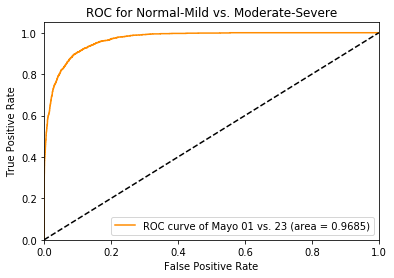

In [33]:
plot_roc(y_pred[:, 1], y_true[:, 1], classes=['Mayo 01 vs. 23'], title='ROC for Normal-Mild vs. Moderate-Severe', 
         savefile = 'output/roc01_23_video.tiff')

{0: 0.9716080121680761}

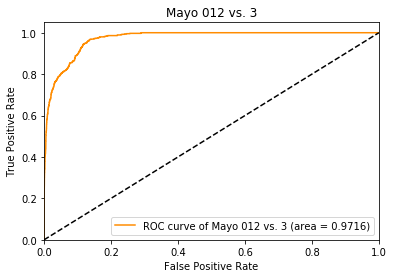

In [34]:
plot_roc(y_pred[:, 2], y_true[:, 2], classes=['Mayo 012 vs. 3'], title='Mayo 012 vs. 3')

In [9]:
mayo_true = video_labels.Mayo_score.reset_index(drop=True)
mayo_true.name = 'Mayo_true'

In [72]:
video_labels.loc[video_labels.SubjectID=='008', 'Mayo_score'].value_counts()

0    194
1      6
Name: Mayo_score, dtype: int64

In [10]:
video_labels.Mayo_score.value_counts()

0    8143
1    1578
2    1123
3     648
Name: Mayo_score, dtype: int64

In [11]:
ys = []
for tst_seed in range(10):
    y = np.load('output/y_pred_video_auc{}.npy'.format(tst_seed))
    ys.append(y)

y_pred = np.stack(ys)

y_pred = y_pred.mean(axis=0)

In [26]:
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)

score4[:, 0] = 1 - y_pred[:, 0]
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [12]:
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)
score4[:, 3] = y_pred[:, 2]
score4[:, 2] = y_pred[:, 1]*(1-y_pred[:,2])
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])*(1-y_pred[:,2])
score4[:, 0] = (1-y_pred[:, 0])*(1-y_pred[:,1])*(1-y_pred[:,2])
mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [17]:
video_labels = video_labels.assign(Prob0 = score4[:, 0])
video_labels = video_labels.assign(Prob1 = score4[:, 1])
video_labels = video_labels.assign(Prob2 = score4[:, 2])
video_labels = video_labels.assign(Prob3 = score4[:, 3])

In [14]:
video_labels = video_labels.assign(Mayo_pred = mayo_pred)

In [15]:
video_labels = video_labels.assign(Mayo_0_pred = (mayo_pred==0))
video_labels = video_labels.assign(Mayo_1_pred = (mayo_pred==1))
video_labels = video_labels.assign(Mayo_2_pred = (mayo_pred==2))
video_labels = video_labels.assign(Mayo_3_pred = (mayo_pred==3))

In [18]:
video_sum_pred = video_labels.groupby('SubjectID')[['Mayo_0_pred', 'Mayo_1_pred', 'Mayo_2_pred', 'Mayo_3_pred', 'Mayo_0', 
                                                    'Mayo_1', 'Mayo_2', 'Mayo_3', 'Prob0', 'Prob1', 'Prob2', 'Prob3']].mean()

In [13]:
video_labels.SubjectID.value_counts()

007           1196
Lycera_001     710
059            685
058            673
079            624
Lycera_002     556
112            499
057            473
046            472
001            434
110            420
045            412
010            380
113            380
Lycera_003     367
052            328
023            327
Lycera_004     322
060            267
091            261
089            253
061            249
093            247
088            219
008            200
116            176
096            169
Lycera_006     128
037             44
Lycera_005      21
Name: SubjectID, dtype: int64

In [70]:
video_sum_pred

,SubjectID,Mayo_0_pred,Mayo_1_pred,Mayo_2_pred,Mayo_3_pred,Mayo_0,Mayo_1,Mayo_2,Mayo_3,Prob0,Prob1,Prob2,Prob3,Summary_score_pred,Summary_score_human
0,001,0.202765,0.444700,0.322581,0.029954,0.384793,0.161290,0.179724,0.274194,0.245858,0.433693,0.251506,0.068944,2,3
1,007,0.637124,0.293478,0.056020,0.013378,1.000000,0.000000,0.000000,0.000000,0.593232,0.278430,0.094010,0.034328,0,0
2,008,0.300000,0.290000,0.395000,0.015000,0.970000,0.030000,0.000000,0.000000,0.270262,0.331674,0.328301,0.069764,2,2
3,010,0.397368,0.465789,0.134211,0.002632,0.618421,0.381579,0.000000,0.000000,0.401436,0.433878,0.146717,0.017969,1,1
4,023,0.085627,0.376147,0.529052,0.009174,0.177370,0.373089,0.446483,0.003058,0.108418,0.366878,0.455853,0.068851,2,3
5,037,0.659091,0.340909,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.577476,0.369108,0.047816,0.005599,0,0
6,045,0.800971,0.089806,0.106796,0.002427,1.000000,0.000000,0.000000,0.000000,0.748775,0.133684,0.100717,0.016825,0,0
7,046,0.974576,0.025424,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.889025,0.103969,0.005943,0.001063,0,0
8,052,0.942073,0.051829,0.006098,0.000000,1.000000,0.000000,0.000000,0.000000,0.812879,0.172807,0.012384,0.001929,0,0
9,057,0.566596,0.357294,0.065539,0.010571,0.716702,0.283298,0.000000,0.000000,0.533738,0.357057,0.094239,0.014965,1,1


In [100]:
video_sum_pred = video_sum_pred.assign(Summary_score_pred=0)

In [45]:
video_sum_pred.loc[video_sum_pred.Mayo_1_pred>0.1, 'Summary_score_pred'] = 1
video_sum_pred.loc[video_sum_pred.Mayo_2_pred>0.1, 'Summary_score_pred'] = 2
video_sum_pred.loc[video_sum_pred.Mayo_3_pred>0.05, 'Summary_score_pred'] = 3

In [101]:
video_sum_pred.loc[video_sum_pred.Prob1>0.25, 'Summary_score_pred'] = 1
video_sum_pred.loc[video_sum_pred.Prob2>0.2, 'Summary_score_pred'] = 2
video_sum_pred.loc[video_sum_pred.Prob3>0.08, 'Summary_score_pred'] = 3

In [21]:
video_sum_pred = video_sum_pred.reset_index()

video_sum_pred.SubjectID = video_sum_pred.SubjectID.astype(str)

video_sum.SubjectID = video_sum.SubjectID.astype(str)

In [22]:
video_sum.loc[video_sum.SubjectID=='58', 'SubjectID'] = '058'

In [23]:
video_sum_pred = pd.merge(video_sum_pred, video_sum[['SubjectID', 'Summary_Mayo_Score']], on='SubjectID')

In [24]:
video_sum_pred.columns = ['SubjectID', 'Mayo_0_pred', 'Mayo_1_pred', 'Mayo_2_pred', 'Mayo_3_pred',
       'Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3', 'Prob0', 'Prob1', 'Prob2',
       'Prob3', 'Summary_score_pred', 'Summary_score_human']

In [102]:
pd.crosstab(video_sum_pred.Summary_score_human, video_sum_pred.Summary_score_pred, margins=True)

Summary_score_pred,0,1,2,3,All
Summary_score_human,,,,,
0,8,2,0,0,10
1,2,4,2,0,8
2,0,1,3,0,4
3,1,0,2,5,8
All,11,7,7,5,30


In [76]:
video_sum_pred.to_csv(path+'Video_summary_prediction.csv', index=False)

In [42]:
pd.crosstab(index=mayo_true, columns=mayo_pred, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,6810,1002,293,38,8143
1,258,940,373,7,1578
2,23,179,813,108,1123
3,3,38,187,420,648
All,7094,2159,1666,573,11492


In [36]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.836301,0.123050,0.035982,0.004667
1,0.163498,0.595691,0.236375,0.004436
2,0.020481,0.159394,0.723954,0.096171
3,0.004630,0.058642,0.288580,0.648148


In [28]:
acc0 = []
acc1 = []
acc2 = []
acc3 = []
kappa_linear = []
kappa_quad = []
for tst_seed in range(10):
    y_pred_avg = np.load('output/y_pred_video_auc{}.npy'.format(tst_seed))
    score4 = np.zeros((y_pred_avg.shape[0], y_pred_avg.shape[1]+1), dtype=float)
    score4[:, 3] = y_pred_avg[:, 2]
    score4[:, 2] = y_pred_avg[:, 1]*(1-y_pred_avg[:,2])
    score4[:, 1] = y_pred_avg[:, 0]*(1-y_pred_avg[:,1])*(1-y_pred_avg[:,2])
    score4[:, 0] = (1-y_pred_avg[:, 0])*(1-y_pred_avg[:,1])*(1-y_pred_avg[:,2])
    mayo_pred_avg = pd.Series(score4.argmax(axis=1), name='Mayo_pred')  
    
    mayo_true = video_labels.Mayo_score
    mayo_true.name = 'Mayo_true'
    
    acc0.append(sum((mayo_pred_avg==0) & (mayo_true==0))/sum(mayo_true==0))
    acc1.append(sum((mayo_pred_avg==1) & (mayo_true==1))/sum(mayo_true==1))
    acc2.append(sum((mayo_pred_avg==2) & (mayo_true==2))/sum(mayo_true==2))
    acc3.append(sum((mayo_pred_avg==3) & (mayo_true==3))/sum(mayo_true==3))

    kappa_linear.append(cohen_kappa_score(mayo_pred_avg.values, mayo_true.values, weights='linear'))
    kappa_quad.append(cohen_kappa_score(mayo_pred_avg.values, mayo_true.values, weights='quadratic'))

In [45]:
print('{0:.4f}'.format(np.mean(acc0)))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(acc0).tconfint_mean()))

0.8332
(0.8259, 0.8404)


In [47]:
print('{0:.4f}'.format(np.mean(kappa_quad)))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(kappa_quad).tconfint_mean()))

0.7849
(0.7774, 0.7924)
